In [1]:
import os
import numpy as np
import katdal as kd
import scipy as sp
from matplotlib import pyplot as plt
import matplotlib
from datetime import datetime
import time
import pickle
import museek.util.tools as tl
import astropy.coordinates as ac
from astropy import units as u
import astropy
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel
import pysm3
import healpy as hp
import gc
import random
from pylab import cm
import matplotlib as mpl
from astropy.time import Time
from matplotlib.colors import ListedColormap

ModuleNotFoundError: No module named 'museek.util.tools'

In [ ]:
#def cat_to_hpx(lon, lat, nside, radec=False):
def cat_to_hpx(ra, dec, nside):
     
    npix = hp.nside2npix(nside)
    
    # convert to theta, phi -> galactic longitude and colatitude in spherical system
    theta = np.radians(90. - dec)
    phi = np.radians(ra)

    # convert to HEALPix indices
    indices = hp.ang2pix(nside, theta, phi)

    indx, counts = np.unique(indices, return_counts=True)

    # fill the fullsky map
    hpx_map = np.zeros(npix, dtype=int)
    hpx_map[indx] = counts

    return hpx_map


In [ ]:
# Import OS module to interact with the operating system
import os

# Define the path for the 2023 data directory
path_2023 = '/idia/projects/hi_im/uhf_2023/sanity_checks'

# Attempt to get the list of all files and directories in the specified path
try:
    dir_list_2023 = os.listdir(path_2023)
    print(f"Files and directories in path for 2023 DATA '{path_2023}':")
    
    # Print all files and directories
    for item in dir_list_2023:
        print(item)
except FileNotFoundError:
    # Handle the case where the directory does not exist
    print(f"The directory {path_2023} does not exist.")
except PermissionError:
    # Handle the case where there are permission issues accessing the directory
    print(f"Permission denied for accessing the directory {path_2023}.")
except Exception as e:
    # Handle any other exceptions that may occur
    print(f"An error occurred while listing the directory {path_2023}: {e}")

# prints all files
print(dir_list_2023)

Files and directories in path for 2023 DATA ' /idia/projects/hi_im/uhf_2023/sanity_checks ' :
['1678743988', '1682448988', '1678295187', '1676313206', '1677020482', '1679592842', '1675643846', '1678734987', '1678122565', '1666198047', '1689003684', '1689176790', '1665938490', '1666630286', '1676657789', '1677777992', '1688399183', '1677183387', '1679247986', '1677011008', '1666205857', '1666032415', '1675623808', '1680626188', '1677002481', '1677195529', '1681143685', '1680798562', '1684087370', '1683492604', '1681920680', '1685641589', '1679419886', '1689090392', '1675210948', '1678726283', '1684781618', '1666293386', '1666024766', '1678467685', '1679605292', '1679615321', '1679333668', '1666284501', '1680644082', '1677174749', '1665679673', '1666111882', '1666370606', 'demo', '1678381591', '1675021905', '1666543907', '1675632179', '1681229848', '1677795989', '1678899080', '1675816512', '1675106912']


Block Number= 1678743988
0
3
Block Number= 1682448988
0
3
Block Number= 1678295187
0
3
Block Number= 1676313206
0
3
Block Number= 1677020482
0
3
Block Number= 1679592842
0
3
Block Number= 1675643846
0
3
Block Number= 1678734987
0
3
Block Number= 1678122565
0
3
Block Number= 1689003684
0
3
Block Number= 1689176790
0
3
Block Number= 1676657789
0
3
Block Number= 1677777992
0
3
Block Number= 1677183387
0
3
Block Number= 1679247986
0
2
Block Number= 1677011008
0
3
Block Number= 1675623808
0
2
Block Number= 1680626188
0
3
Block Number= 1677002481
0
3
Block Number= 1681143685
0
3
Block Number= 1680798562
0
3
Block Number= 1683492604
0
3
Block Number= 1681920680
0
3
Block Number= 1685641589
0
3
Block Number= 1679419886
0
3
Block Number= 1689090392
0
3
Block Number= 1675210948
0
4
Block Number= 1678726283
0
3
Block Number= 1684781618
0
3
Block Number= 1678467685
0
3
Block Number= 1679605292
0
3
Block Number= 1679615321
0
3
Block Number= 1679333668
0
3
Block Number= 1680644082
0
4
Block Number= 

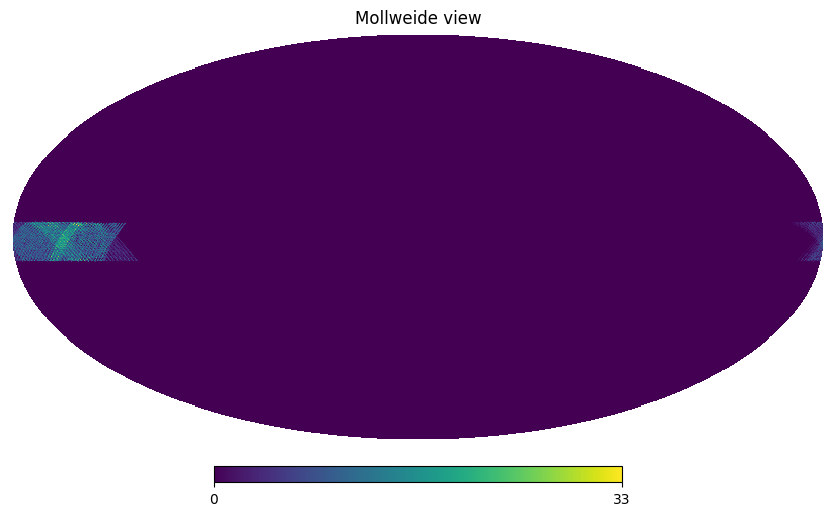

In [ ]:
#########  Read the calibrated data and raw visibility ###############
from museek.enums.result_enum import ResultEnum

# Open and read the list of files for 2023 data
with open("sanity_2023_list_clean2.txt", "r") as f:
    file_blocks_23 = f.read().replace('[', '').replace(']', '').replace('\'', '').replace('\\ ', '').replace('\n', '')
    file_blocks_2023 = file_blocks_23.split(", ")

# Initialize Healpix parameters
nside = 256
npix = hp.nside2npix(nside)
map_final = np.zeros(npix)

# Loop through each data block and process the data
for i in range(len(file_blocks_2023)):
    block = file_blocks_2023[i]
    data_path = '/idia/projects/hi_im/uhf_2023/sanity_checks/'
    
    print("Block Number =", file_blocks_2023[i])
    
    # Load the scan data from the pickle file
    with open(os.path.join(data_path, block, 'scan_track_split_plugin.pickle'), 'rb') as file:
        data_read = pickle.load(file)
    
    # Extract necessary data from the loaded data
    scan_data = data_read.get(ResultEnum.SCAN_DATA).result
    timestamps = scan_data.timestamps.array.squeeze()
    ra = scan_data.right_ascension.array.squeeze()
    dec = scan_data.declination.array.squeeze()
    
    receiver_list = [str(receiver) for receiver in scan_data.receivers]
    antenna_list = scan_data._antenna_name_list
    
    receivers = scan_data.receivers
    antennas = scan_data.antennas
    
    # Extract RA and Dec for a specific antenna
    block_number_ra = ra[:, antenna_list.index('m001')]
    block_number_dec = dec[:, antenna_list.index('m001')]
    
    # Convert RA and Dec to Healpix map
    hpx_map_block = cat_to_hpx(block_number_ra, block_number_dec, nside=nside)
    
    mmin, mmax = min(hpx_map_block), max(hpx_map_block)
    
    print("Min value in block:", mmin)
    print("Max value in block:", mmax)
    
    # Accumulate the Healpix maps
    map_final += hpx_map_block
    
# Display the final accumulated map using mollview
hp.mollview(map_final)

[300. 330. 360.   0.  30.  60.  90. 120. 150. 180. 210. 240. 270.]
[ 90.  60.  30.   0. -30. -60. -90.]


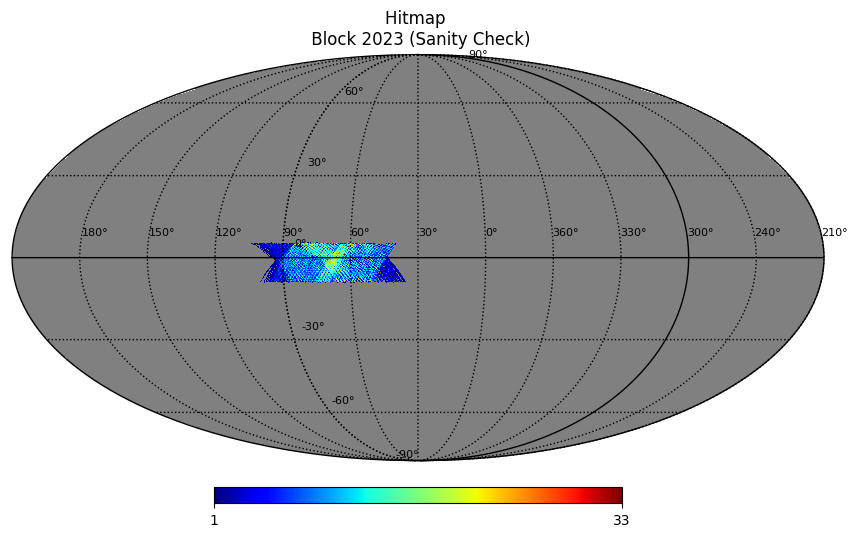

In [ ]:
# Parameters for the map
rotation = 90
xsize = 13
ysize = 7

# Generate phi and theta arrays for coordinates
phi = np.linspace(0., 2 * np.pi, xsize)
phi_deg = np.roll(phi / np.pi * 180, int(rotation * 180 / np.pi / 30.) + 1)
print("Phi degrees:", phi_deg)

theta = np.linspace(-np.pi / 2., np.pi / 2, ysize)
theta_deg = (theta / np.pi * 180)[::-1]
print("Theta degrees:", theta_deg)

# Handle NaN values in the final map
map_final_nan = np.where(map_final == 0, np.NaN, map_final)

# Plot the map using mollview
hp.mollview(map_final_nan, rot=[120], cmap='jet', title='Hitmap \n Block 2023 (Sanity Check)')
hp.graticule()

# Add custom graticule labels
shift_x = 82.
for xx in range(xsize - 1):
    hp.projtext(shift_x / 180 * np.pi, phi[xx], f"{phi_deg[xx]:.0f}°", fontsize=8, color='black')

shift_y = 175.
for yy in range(ysize):
    hp.projtext(theta[yy] + np.pi / 2. - 4 / 180. * np.pi, shift_y / 180 * np.pi, f"{theta_deg[yy]:.0f}°", fontsize=8, color='black')

In [ ]:
# Import the OS module to interact with the operating system
import os

# Define the path for the 2024 data directory
path_2024 = '/idia/projects/hi_im/SCI-20230907-MS-01/'

# Get the list of all files and directories in the specified path
try:
    dir_list_2024 = os.listdir(path_2024)
    print(f"Files and directories in path for 2024 DATA '{path_2024}':")
    
    # Print all files and directories found in the path
    for item in dir_list_2024:
        print(item)
        
except FileNotFoundError:
    # Handle the case where the directory does not exist
    print(f"The directory {path_2024} does not exist.")
except PermissionError:
    # Handle the case where there are permission issues accessing the directory
    print(f"Permission denied for accessing the directory {path_2024}.")
except Exception as e:
    # Handle any other exceptions that may occur
    print(f"An error occurred while listing the directory {path_2024}: {e}")
# prints all files
print(dir_list_2024)

Files and directories in path for 2024 DATA ' /idia/projects/hi_im/SCI-20230907-MS-01/ ' :
['1711386689', '1710006809', '1710627984', '1711223036', '1713640800', '1715978497', '1713286887', '1711831588', '1716507875', '1713297934', '1714087820', '1710524489', '1711061184', '1711128207', '1712006187', '1716421250', '1710437786', '1710541914', '1710964969', '1710609769', '1711395125', '1710178583', '1711214488', '1716154890', '1710713032']


Block Number= 1711386689
0
3
Block Number= 1713546092
0
3
Block Number= 1710006809
0
3
Block Number= 1710533408
0
3
Block Number= 1710627984
0
3
Block Number= 1713977489
0
3
Block Number= 1709488889
0
3
Block Number= 1710618377
0
3
Block Number= 1715280867
0
4
Block Number= 1715032586
0
3
Block Number= 1713210090
0
3
Block Number= 1716155523
0
3
Block Number= 1710369087
0
3
Block Number= 1713640800
0
3
Block Number= 1713813967
0
4
Block Number= 1713631891
0
3
Block Number= 1711923089
0
3
Block Number= 1708710691
0
3
Block Number= 1712015185
0
3
Block Number= 1710888742
0
3
Block Number= 1713201088
0
3
Block Number= 1712172417
0
3
Block Number= 1709746890
0
4
Block Number= 1713286887
0
3
Block Number= 1711831588
0
4
Block Number= 1713891087
0
3
Block Number= 1714428474
0
3
Block Number= 1710358887
0
3
Block Number= 1712183487
0
3
Block Number= 1709919689
0
3
Block Number= 1713297934
0
3
Block Number= 1713037411
0
3
Block Number= 1716498372
0
3
Block Number= 1710956448
0
3
Block Number= 

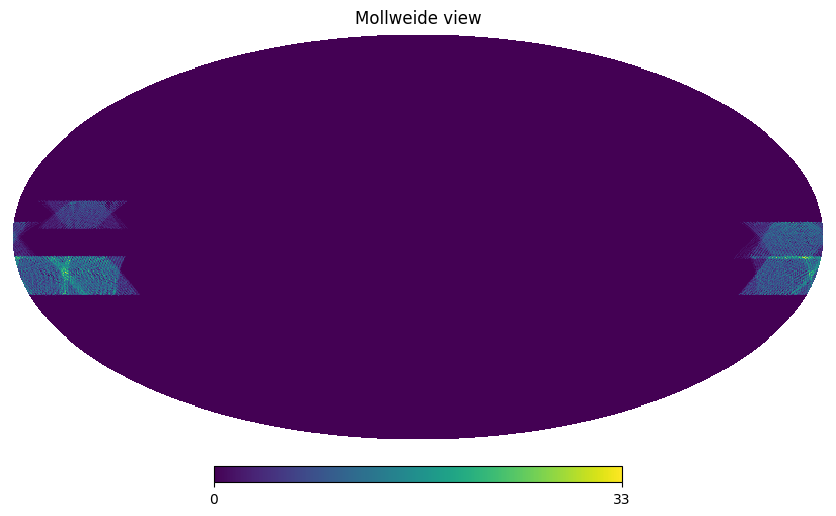

In [ ]:
# Open and read the list of files for 2024 data
with open("sanity_2024_list_clean.txt", "r") as f:
    file_blocks_24 = f.read().replace('[', '').replace(']', '').replace('\'', '').replace('\ ', '').replace('\n', '')
    file_blocks_2024 = file_blocks_24.split(", ")

# Initialize Healpix parameters
nside = 256
npix = hp.nside2npix(nside)
map_final_2024 = np.zeros(npix)

# Loop through each data block and process the data
for i in range(len(file_blocks_2024)):
    block = file_blocks_2024[i]
    data_path = '/idia/projects/hi_im/uhf_2024/sanity_checks/'
    
    print("Block Number =", file_blocks_2024[i])
    
    # Load the scan data from the pickle file
    with open(os.path.join(data_path, block, 'scan_track_split_plugin.pickle'), 'rb') as file:
        data_read = pickle.load(file)
    
    # Extract necessary data from the loaded data
    scan_data = data_read.get(ResultEnum.SCAN_DATA).result
    timestamps = scan_data.timestamps.array.squeeze()
    ra = scan_data.right_ascension.array.squeeze()
    dec = scan_data.declination.array.squeeze()
    
    receiver_list = [str(receiver) for receiver in scan_data.receivers]
    antenna_list = scan_data._antenna_name_list
    
    receivers = scan_data.receivers
    antennas = scan_data.antennas
    
    # Extract RA and Dec for a specific antenna
    block_number_ra = ra[:, antenna_list.index('m001')]
    block_number_dec = dec[:, antenna_list.index('m001')]
    
    # Convert RA and Dec to Healpix map
    hpx_map_block = cat_to_hpx(block_number_ra, block_number_dec, nside=nside)
    
    mmin, mmax = min(hpx_map_block), max(hpx_map_block)
    
    print("Min value in block:", mmin)
    print("Max value in block:", mmax)
    
    # Accumulate the Healpix maps
    map_final_2024 += hpx_map_block
    
# Display the final accumulated map using mollview
hp.mollview(map_final_2024, title="Hit Map 2024")

[300. 330. 360.   0.  30.  60.  90. 120. 150. 180. 210. 240. 270.]
[ 90.  60.  30.   0. -30. -60. -90.]


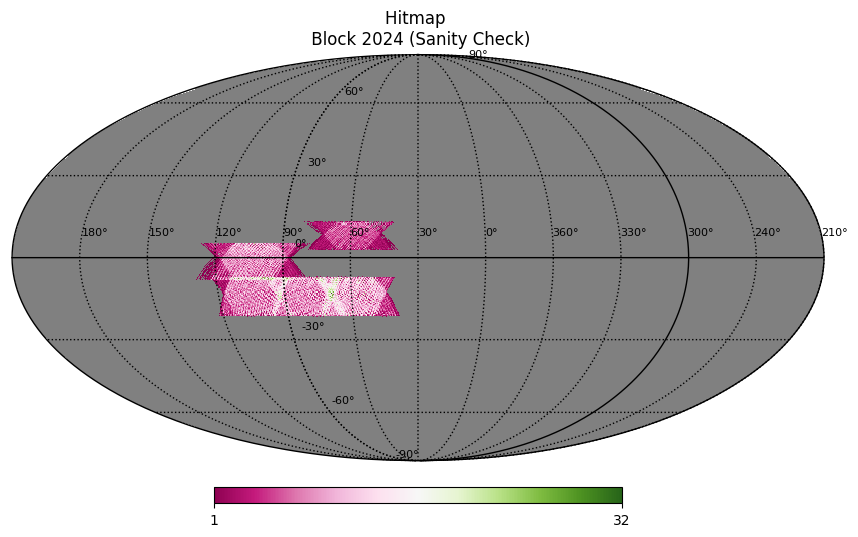

In [ ]:
# Define rotation and size parameters for the map
rotation = 90
xsize = 13
ysize = 7

# Generate phi and theta arrays for coordinates
phi = np.linspace(0., 2 * np.pi, xsize)
phi_deg = np.roll(phi / np.pi * 180, int(rotation * 180 / np.pi / 30.) + 1)
print("Phi degrees:", phi_deg)

theta = np.linspace(-np.pi / 2., np.pi / 2, ysize)
theta_deg = (theta / np.pi * 180)[::-1]
print("Theta degrees:", theta_deg)

# Handle NaN values in the final map
map_final_2024_nan = np.where(map_final_2024 == 0, np.NaN, map_final_2024)

# Plot the map using mollview with specific settings
hp.mollview(map_final_2024_nan, rot=[120], cmap='PiYG', title='Hitmap \n Block 2024 (Sanity Check)')
hp.graticule()

# Add custom graticule labels for longitude (phi)
shift_x = 82.
for xx in range(xsize - 1):
    hp.projtext(shift_x / 180 * np.pi, phi[xx], f"{phi_deg[xx]:.0f}°", fontsize=8, color='black')

# Add custom graticule labels for latitude (theta)
shift_y = 175.
for yy in range(ysize):
    hp.projtext(theta[yy] + np.pi / 2. - 4 / 180. * np.pi, shift_y / 180 * np.pi, f"{theta_deg[yy]:.0f}°", fontsize=8, color='black')


/tmp/ipykernel_1018853/821989650.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmp = mpl.cm.get_cmap('gray')
/tmp/ipykernel_1018853/821989650.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmp = mpl.cm.get_cmap('Greys')


[300. 330. 360.   0.  30.  60.  90. 120. 150. 180. 210. 240. 270.]
[ 90.  60.  30.   0. -30. -60. -90.]


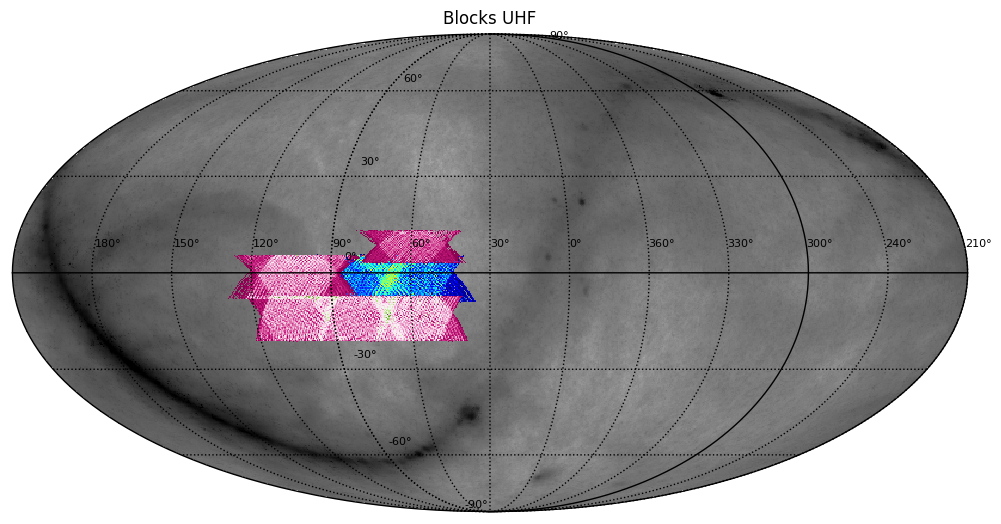

In [ ]:
def rot_map(nside, map_in, coord_in='G', coord_out='C'):
    """
    Function to rotate a Healpix map from input coordinates to output coordinates.

    Parameters:
    - nside (int): Resolution parameter for Healpix map.
    - map_in (array): Input Healpix map to be rotated.
    - coord_in (str): Input coordinate system ('G' for Galactic, 'C' for Celestial).
    - coord_out (str): Output coordinate system ('G' for Galactic, 'C' for Celestial).

    Returns:
    - map_rot (array): Rotated Healpix map.
    """
    npix = hp.nside2npix(nside)
    map_rot = np.zeros(npix)
    
    ipix = np.arange(npix)
    theta, phi = hp.pix2ang(nside, ipix)
    r = hp.Rotator(coord=[coord_out, coord_in]) 
    theta_rot, phi_rot = r(theta, phi)

    ipix_rot = hp.ang2pix(nside, theta_rot, phi_rot)
    map_rot = map_in[ipix_rot]

    return map_rot
    
nside=512
sky1 = pysm3.Sky(nside=nside, preset_strings=["s1"])
map1_1GHz = sky1.get_emission(1 * u.GHz)[0,:].value

map_synch_rot = rot_map(nside,map1_1GHz,coord_in='G',coord_out='C')

cmp = mpl.cm.get_cmap('gray')

# Choose colormap
cmap = plt.cm.gray

fig = plt.figure(figsize=(10, 7))

# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))

# Set alpha
my_cmap[:,-1] = np.linspace(0, 1., cmap.N)

# Create new colormap
my_cmap = ListedColormap(my_cmap)

cmp = mpl.cm.get_cmap('Greys')
cmp.set_bad('#000000')

rotation=90
xsize=13
phi = np.linspace(0.,2*np.pi, xsize)
phi_deg = np.roll(phi/np.pi*180,int(rotation*180/np.pi/30.)+1)
print(phi_deg)
ysize=7
theta = np.linspace(-np.pi/2.,np.pi/2, ysize)
theta_deg = (theta/np.pi*180)[::-1]
print(theta_deg)


hp.mollview(np.log10(map_synch_rot),rot=[120],cmap=cmp,max=7.5, min=3.5,fig=1, badcolor='#00000000', cbar=False)
hp.mollview((map_final_nan),reuse_axes=True,rot=[120],max=34, min=1,fig=1,badcolor='#00000000',title='Blocks UHF', cmap='jet',cbar=False)
hp.mollview((map_final_2024_nan),reuse_axes=True,rot=[120],fig=1,badcolor='#00000000',title='Blocks UHF', cmap='PiYG',cbar=False)
hp.graticule()

shift_x = 82.
for xx in range(xsize-1):
    hp.projtext(shift_x/180*np.pi,phi[xx], str("%.0f" % phi_deg[xx])+'\N{DEGREE SIGN}',fontsize=8,color='black')
shift_y = 175.
for yy in range(ysize):
    hp.projtext(theta[yy]+np.pi/2.-4/180.*np.pi, shift_y/180*np.pi,str("%.0f" % theta_deg[yy])+'\N{DEGREE SIGN}',fontsize=8,color='black')

# Save the figure as a PNG file with high resolution
plt.savefig("synch_data2023_data2024.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


/tmp/ipykernel_1018853/2390658053.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmp = mpl.cm.get_cmap('gray')
/tmp/ipykernel_1018853/2390658053.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmp = mpl.cm.get_cmap('Greys')


[300. 330. 360.   0.  30.  60.  90. 120. 150. 180. 210. 240. 270.]
[ 90.  60.  30.   0. -30. -60. -90.]


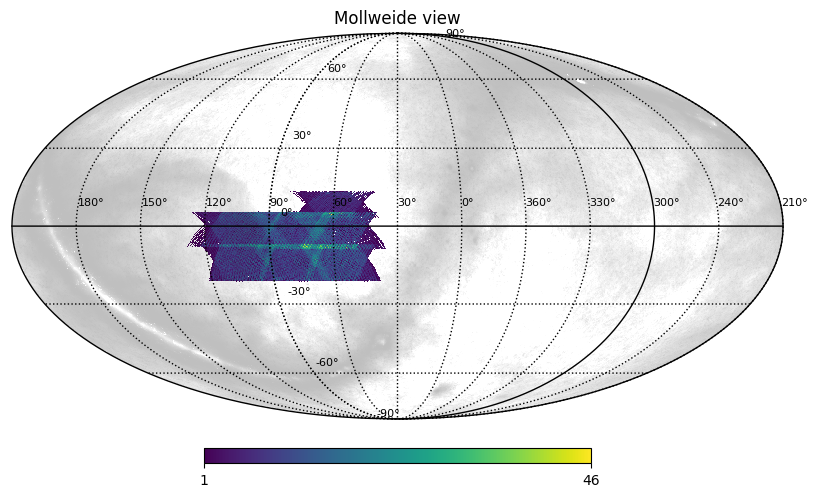

In [ ]:
def rot_map(nside, map_in, coord_in='G', coord_out='C'):
    """
    Function to rotate a Healpix map from input coordinates to output coordinates.

    Parameters:
    - nside (int): Resolution parameter for Healpix map.
    - map_in (array): Input Healpix map to be rotated.
    - coord_in (str): Input coordinate system ('G' for Galactic, 'C' for Celestial).
    - coord_out (str): Output coordinate system ('G' for Galactic, 'C' for Celestial).

    Returns:
    - map_rot (array): Rotated Healpix map.
    """
    npix = hp.nside2npix(nside)
    map_rot = np.zeros(npix)
    
    ipix = np.arange(npix)
    theta, phi = hp.pix2ang(nside, ipix)
    r = hp.Rotator(coord=[coord_out, coord_in]) 
    theta_rot, phi_rot = r(theta, phi)

    ipix_rot = hp.ang2pix(nside, theta_rot, phi_rot)
    map_rot = map_in[ipix_rot]

    return map_rot

# Define parameters and generate a synthetic sky map
nside = 512
sky1 = pysm3.Sky(nside=nside, preset_strings=["s1"])
map1_1GHz = sky1.get_emission(1 * u.GHz)[0, :].value

# Rotate the synthetic sky map
map_synch_rot = rot_map(nside, map1_1GHz, coord_in='G', coord_out='C')

# Define colormap adjustments
cmap = plt.cm.gray
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:, -1] = np.linspace(0, 1., cmap.N)
my_cmap = ListedColormap(my_cmap)

# Define rotation angles and coordinate arrays
rotation = 90
xsize = 13
phi = np.linspace(0., 2 * np.pi, xsize)
phi_deg = np.roll(phi / np.pi * 180, int(rotation * 180 / np.pi / 30.) + 1)
print("Phi degrees:", phi_deg)

ysize = 7
theta = np.linspace(-np.pi / 2., np.pi / 2, ysize)
theta_deg = (theta / np.pi * 180)[::-1]
print("Theta degrees:", theta_deg)

# Combine maps and handle NaN values
map_MS = map_final_2024 + map_final
map_MS_nan = np.where((map_MS) == 0, np.NaN, (map_MS))

# Plotting using Healpy mollview
fig = plt.figure(figsize=(10, 7))
hp.mollview((map_MS_nan), hold=True, rot=[120], fig=1, title='Blocks UHF', cmap='viridis', badcolor='#00000000', cbar=True)
hp.mollview(np.log10(map_synch_rot), reuse_axes=True, rot=[120], cmap=my_cmap, max=7.5, min=5.85, badcolor='#00000000', fig=1, cbar=False)
hp.graticule()

# Add longitude and latitude annotations
shift_x = 82.
for xx in range(xsize - 1):
    hp.projtext(shift_x / 180 * np.pi, phi[xx], f"{phi_deg[xx]:.0f}°", fontsize=8, color='black')

shift_y = 175.
for yy in range(ysize):
    hp.projtext(theta[yy] + np.pi / 2. - 4 / 180. * np.pi, shift_y / 180 * np.pi, f"{theta_deg[yy]:.0f}°", fontsize=8, color='black')

# Save the figure as a PNG file with high resolution
plt.savefig("synch_data2023_data2024_samecolor.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

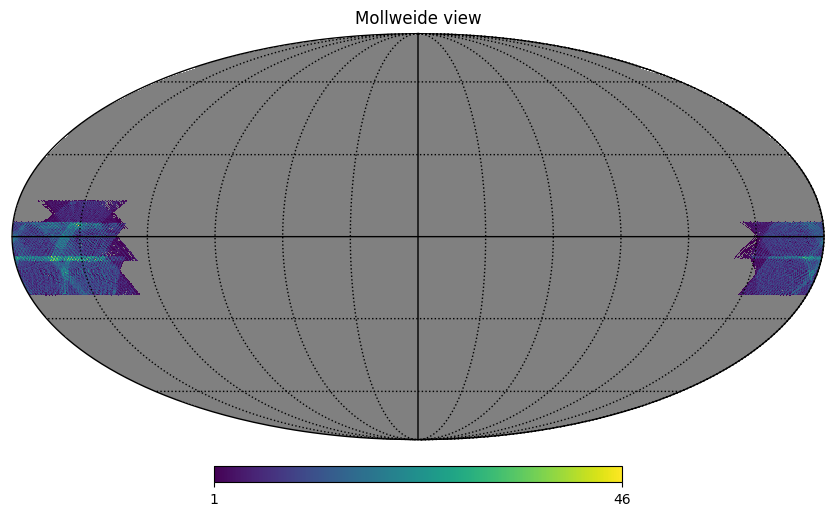

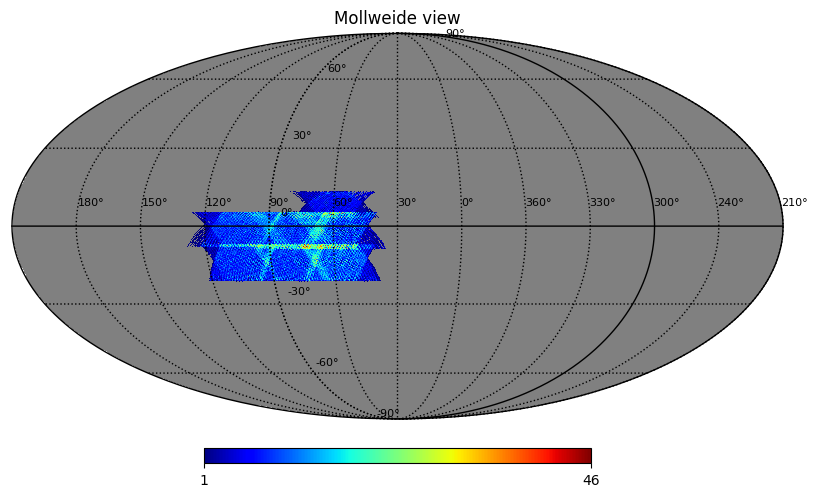

In [ ]:
# Get the colormap colors

map_MS = map_final_2024 + map_final
map_MS_nan = np.where((map_MS)==0, np.NaN, (map_MS))
hp.mollview(map_MS_nan)
hp.graticule()

#my_cmap = cmap(np.arange(cmap.N))
#fig = plt.figure(figsize=(10, 7))

# Set alpha
#my_cmap[:,-1] = np.linspace(0, 1., cmap.N)

# Create new colormap
#my_cmap = ListedColormap(my_cmap)

#cmp = mpl.cm.get_cmap('jet')
#cmp.set_bad('#000000')
fig = plt.figure(figsize=(10, 7))

hp.mollview(map_MS_nan, cbar=True, cmap='jet', rot=[120,0],fig=1, hold=True)
#hp.mollview(map_final_2024_nan, cbar=True, cmap='cividis',rot=[120,0],fig=1, badcolor='#00000000', reuse_axes=True)

hp.graticule()
shift_x = 82.
for xx in range(xsize-1):
    hp.projtext(shift_x/180*np.pi,phi[xx], str("%.0f" % phi_deg[xx])+'\N{DEGREE SIGN}',fontsize=8,color='black')
shift_y = 175.
for yy in range(ysize):
    hp.projtext(theta[yy]+np.pi/2.-4/180.*np.pi, shift_y/180*np.pi,str("%.0f" % theta_deg[yy])+'\N{DEGREE SIGN}',fontsize=8,color='black')

# Save the figure as a PNG file with high resolution
#plt.savefig("hpallblockswithoutruins.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()
#there are some little n